# This files shows different implemntations and version of our code

* to save time, run all cell now, while reading trough code. It will take about 5 min to simulate all variations and save them in gif and plots

## The block below is showing the first implementation without runge kutta method

This allows us to have an initial point to compare future resutls with

In [410]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation, PillowWriter

In here we approximate with finite difference method

# COMMENT 1
In the following, using the np.sum method seems fine - the error (reduction) in the density is mostly due to the discretization of the problem (oberserve that if you increase nx form 101 to 201, the error reduces in the sense that more of the density is conserved), and you should be able to quantify this my looking at how the error term in the finite difference method looks (scales like $O(dx^2)$ if i remember correctly) - so it is not really a problem that you are loosing density as it is an expected part of the discretization. As long as the CFL criteria is not broken, this should not be a problem. You can, if you have time, try to estimate how big you would expect the error to be. 

In [411]:
# define initial conditions functions
def initial_condition_sine(x):
    # returns sine wave values for the given grid
    return np.sin(x)

def initial_condition_square_wave(x):
    # returns square wave values for the given grid
    return np.where((x >= np.pi) & (x <= 2 * np.pi), 1.0, 0.0)

def initial_condition_gaussian(x):
    gaussian = np.exp(-0.5 * ((x - np.pi) / 0.5)**2)

    #  area under thecurve using the trapezoidal rule
    area = np.trapezoid(gaussian, x)
    
    # normalized Gaussian by dividing it by its area
    return gaussian / area


# set initial conditions dictionary
initial_conditions = {
    # 'Sine Wave': initial_condition_sine,
    # 'Square Wave': initial_condition_square_wave,
    'Gaussian': initial_condition_gaussian
}

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapezoid): 1.000000
Final area under the curve (np.sum): 0.962858
Final area under the curve (np.trapezoid): 0.958068


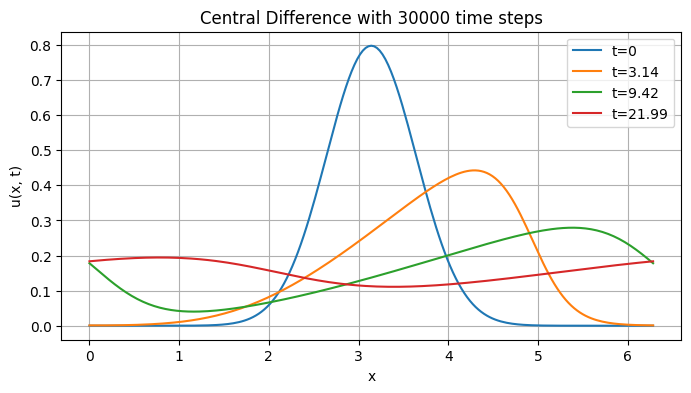

In [412]:
# define parameters
nx = 201         # number of spatial points
L = 2.0 * np.pi  # length of the domain
dx = L / (nx - 1)  # spatial step size
x = np.linspace(0, L, nx)  # spatial grid

nu = 0.07  # viscosity coefficient

# define time parameters
nt = 30000     # number of time steps
sigma = 0.2      # cfl number for advection
max_u = 1.0      # maximum expected value of u

# compute time step sizes
dt_adv = sigma * dx / max_u  # time step for advection
dt_diff = dx**2 / (2 * nu)   # time step for diffusion
dt = min(dt_adv, dt_diff)    # choose the smaller time step for stability

# define burgers' equation update function
def update_burgers(u, dt, dx, nu):
    # performs one time step of burgers' equation update
    un = u.copy()  # create a copy of the current state
    # update the internal points
    u[1:-1] = un[1:-1] - dt * un[1:-1] * (un[1:-1] - un[0:-2]) / dx + \
            nu * dt * (un[2:] - 2 * un[1:-1] + un[0:-2]) / dx**2
    # update the first point using periodic boundary conditions
    u[0] = un[0] - dt * un[0] * (un[0] - un[-2]) / dx + \
        nu * dt * (un[1] - 2 * un[0] + un[-2]) / dx**2
    u[-1] = u[0]  # enforce periodic boundary at the last point
    return u

# define a function to calculate and print area under the curve
def calculate_and_print_area(u, x, label):
    # calculates area using three methods and prints results
    sum_area = np.sum(u) * (x[1] - x[0])  # area using summation
    trapz_area = np.trapezoid(u, x)  # area using trapezoidal rule

    # print the calculated areas with the provided label
    print(f"{label} area under the curve (np.sum): {sum_area:.6f}")
    print(f"{label} area under the curve (np.trapezoid): {trapz_area:.6f}")

    return sum_area

plot_steps = [0, 500, 1500, 3500, 35000]

# begin simulation
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)  # get the initial condition
    u = u0.copy()  # create a copy to simulate
    
    # calculate and print the initial area
    calculate_and_print_area(u, x, "Initial")

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'Central Difference with {nt} time steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # start time-stepping simulation
    for n in range(1, nt + 1):
        u = update_burgers(u, dt, dx, nu)  # update solution
        
        # plot intermediate steps for visualization
        if n in plot_steps:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

    # calculate and print the final area
    calculate_and_print_area(u, x, "Final")
    
    # finalize and display the plot
    plt.legend()
    plt.grid(True)
    plt.show()


## At this block we introduce new methods: 
- runge kutta 
- spacial derivative 
- right hand side of Burgers


I will define them in separate block, so that they can be used later without need to repeat them in code

# COMMENT 2 
The discretization below looks fine - and I think you should show code blocks like this in your final report, as it is a big part of the project :)

In [413]:
# define function to compute spatial derivatives
def spatial_derivatives(u, dx, nu):
    # computes first and second spatial derivatives with periodic boundaries
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    dudx[1:-1] = (u[2:] - u[:-2]) / (2 * dx)
    dudx[0] = (u[1] - u[-2]) / (2 * dx)  # periodic left boundary
    dudx[-1] = dudx[0]                   # periodic right boundary

    d2udx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / (dx**2)
    d2udx2[0] = (u[1] - 2 * u[0] + u[-2]) / (dx**2)  # periodic left boundary
    d2udx2[-1] = d2udx2[0]                          # periodic right boundary

    return dudx, d2udx2

# define function to compute the rhs of Burgers' equation
def rhs_burgers(u, dx, nu):
    # computes the right-hand side of burgers' equation
    dudx, d2udx2 = spatial_derivatives(u, dx, nu)
    return -u * dudx + nu * d2udx2

# define rk4 step method
def rk4_step(u, dt, dx, nu):
    # performs one rk4 time integration step
    k1 = rhs_burgers(u, dx, nu)
    k2 = rhs_burgers(u + 0.5 * dt * k1, dx, nu)
    k3 = rhs_burgers(u + 0.5 * dt * k2, dx, nu)
    k4 = rhs_burgers(u + dt * k3, dx, nu)

    return u + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

The main loop:

# Comment 3
Ah, here the density is nicely conserved using the more sophiscated method of np.trapz

Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapezoid): 1.000000
Final area under the curve (np.sum): 1.005876
Final area under the curve (np.trapezoid): 1.000000


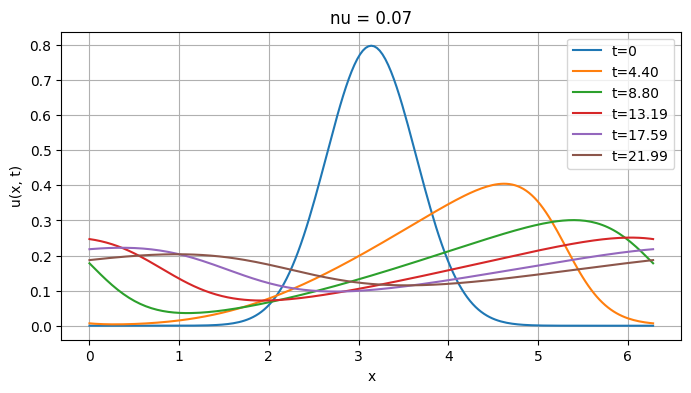

In [414]:
# We keep parameters the same as in previous simulations
nx = 201         # number of spatial points
L = 2.0 * np.pi  # length of the domain
dx = L / (nx - 1)  # spatial step size
x = np.linspace(0, L, nx)  # spatial grid

nu = 0.07  # viscosity coefficient

# but we define time parameters
nt = 3500        # number of time steps
sigma = 0.2      # cfl number for advection
max_u = 1.0      # maximum expected value of u

# plot_steps = [0, 100, 160, 195]

# compute time step sizes
dt_adv = sigma * dx / max_u  # time step for advection
# dt_diff = dx**2 / (2 * nu)   # time step for diffusion
dt_diff = 9999  # time step for diffusion
dt = min(dt_adv, dt_diff)    # choose the smaller time step for stability

  
# simulation loop
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)  # compute initial condition
    u = u0.copy()    # initialize solution

    # calculate and print initial area
    start = calculate_and_print_area(u, x, "Initial")

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    plt.title(f'nu = {nu}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an    rk4 step
        u = rk4_step(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        # if n in plot_steps:
        if n % (nt/5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

    # calculate and print final area
    end = calculate_and_print_area(u, x, "Final")
    # finalize and display plot
    plt.legend()
    plt.grid(True)
    plt.show()

Here we can see that becuase we use Kutta insted of just fininte element approx. We get a better results in terms of Error in the end of the simulation. Which make sense and was expected

# Below is just animated code. Amination is attached in the discord

In [415]:
# method to animate code for easier observation of the values change
def create_animation(x, u_hist, name):
    fig, ax = plt.subplots()
    line, = ax.plot(x, u_hist[0], label='u(x,t)')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0,0.3)
    ax.grid(True)

    def animate(i):
        line.set_ydata(u_hist[i])
        return line,

    ani = FuncAnimation(fig, animate, frames=len(u_hist), interval=10, blit=True)

    filename = f"{name.replace(' ', '_')}.gif"
    ani.save(filename, writer=PillowWriter(fps=30))
    print(f"Saved animation: {filename}")

In [416]:
def initial_condition_flat(x):
    # flat region of 0.5 from x=1 to x=3 and 0 elsewhere
    u = np.zeros_like(x)
    mask = (x >= 1) & (x <= 4.5)
    u[mask] = 3

    area = np.trapezoid(u, x)
    return u / area

initial_conditions = {
    # f'Gaussian': initial_condition_gaussian,
    f'Flat Line': initial_condition_flat
}


Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapezoid): 1.000000
0.07
Final area under the curve (np.sum): 0.990841
Final area under the curve (np.trapezoid): 0.985911
Saved animation: Flat_Line_FLAAAT.gif


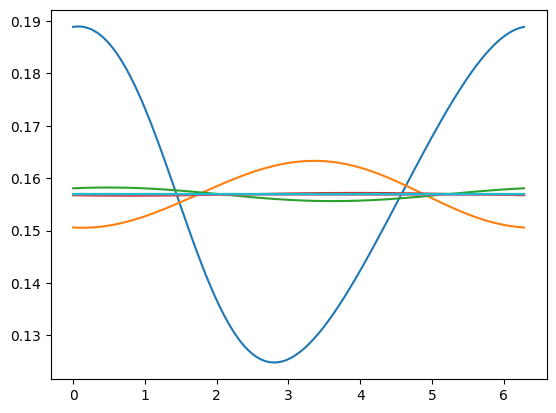

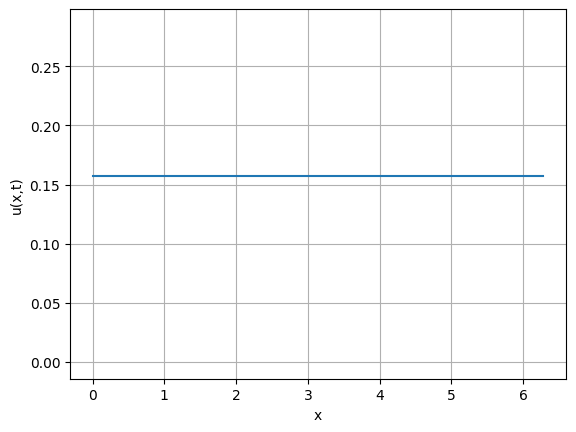

In [138]:
nt = 3500 # number of time steps decreased to save animation time, approx: 0.75 min
nu = 0.07

for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()
    
    calculate_and_print_area(u, x, "Initial")

    print(nu)
    u_hist = [u.copy()]

    for n in range(1, nt + 1):
        u = update_burgers(u, dt, dx, nu)

        if n % (nt / 10) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")
            
        if n % math.floor((nt/600)) == 0:
            u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    # create and save animation
    create_animation(x, u_hist, f"{name} FLAAAT")

## In this section we will introduce noise to the system

To do so, we need to make sure those values will not ruin the system itself, --> will not go over the defined boudaries

# Comment 4
Even though this Gaussian noise approach does not work, it think it is worth noting in the report that you tried, and why it did not work.

In [417]:
def try_find_index_for_noise(u, candidates, noise_val, lower_bound=0.0, upper_bound=1.0, max_tries=100):
    """
    This method helps find a suitable index in given {u} where 'noise_val' can be applied
    so that we still will keep the values within lowerand upper bounds. Else, we just don't apply this noise
    Later this function is also used for impulse noise verification.

    Returns:
        - chosen_index if found
        - None if not found
    """
    cand_copy = candidates.copy()
    for _ in range(max_tries):
        if len(cand_copy) == 0:
            break
        idx = np.random.choice(cand_copy)
        if lower_bound <= u[idx] + noise_val <= upper_bound:
            return idx
        else:
            # not suitable, remove this candidate and try another
            cand_copy = cand_copy[cand_copy != idx]

    return None


In [418]:
def add_guassian_noise(u, noise_std=0.01, fraction=0.1, max_tries=20):
    '''
    This function adds guassian noise to the u, with fraction of 10% from all values. Can be changed.
    Also it takes up to n times to find additional point, if one of them have failed.
    '''
    nx = len(u)  # number of spatial points
    num_noise_pairs = int(nx * fraction)  # number of noise pairs to apply-fraction
    
    # Generate Gaussian noise
    noise_values = np.random.normal(loc=0.0, scale=noise_std, size=num_noise_pairs)
    
    # shuffled list of indices for positive and negative noise candidates
    all_indices = np.arange(nx)
    np.random.shuffle(all_indices)
    pos_candidates = all_indices.copy()
    
    np.random.shuffle(all_indices)
    neg_candidates = all_indices.copy()
    
    for noise_val in noise_values:
        # positive noise
        pos_idx = try_find_index_for_noise(
            u=u,
            candidates=pos_candidates,
            noise_val=noise_val,
            lower_bound=0.0,
            upper_bound=1.0,
            max_tries=max_tries
        )
        
        if pos_idx is None:
            # if unable to find a suitable index for positive noise; skip to next noise_val
            continue
        
        # negative noise
        neg_idx = try_find_index_for_noise(
            u=u,
            candidates=neg_candidates,
            noise_val=-noise_val,  # negative noise from positive
            lower_bound=0.0,
            upper_bound=1.0,
            max_tries=max_tries
        )
        
        if neg_idx is None:
            continue
        
        # apply the noise to the selected indexes
        u[pos_idx] += noise_val
        u[neg_idx] -= noise_val
        
        # remove used indesx from candidates -- no repeat
        pos_candidates = pos_candidates[pos_candidates != pos_idx]
        neg_candidates = neg_candidates[neg_candidates != neg_idx]
    
    # periodic boundary
    u[-1] = u[0]
    
    return u


Initial area under the curve (np.sum): 1.000000
Initial area under the curve (np.trapezoid): 1.000000


KeyboardInterrupt: 

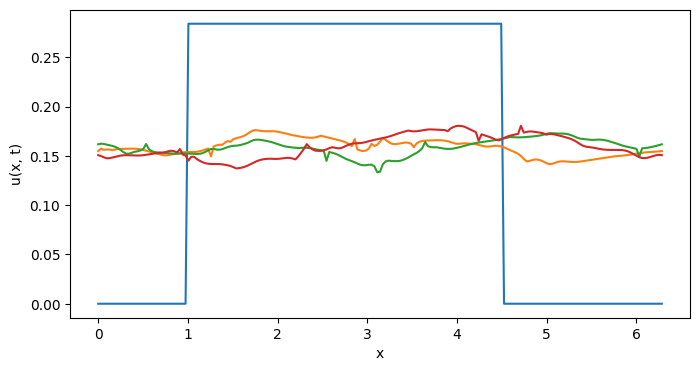

In [338]:
# Time parameters
nt = 30000
 
# plot_steps = [0, 100, 160, 195]

noise_std = 0.01 # how big is the noise
number_of_steps = 1 # APPLY NOISE EVERY NUMBER OF STEPS. TO PLAY AROUND
fraction = 0.01 # what % of area will have noise


# main loop for test
for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()
    
    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    # plot the initial condition
    plt.figure(figsize=(8, 4))
    plt.plot(x, u, label="t=0")
    # plt.title(f'{name} with Guassian noise. {nt} steps')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)

        if n % number_of_steps == 0:
            u = add_guassian_noise(u, noise_std, fraction=fraction, max_tries=20)
            
        # plot 5 time steps of the solution progress
        if n % (nt / 5) == 0:
            plt.plot(x, u, label=f"t={n * dt:.2f}")

        if n % math.floor((nt/200)) == 0:
            u_hist.append(u.copy())
        

    calculate_and_print_area(u, x, "Final")

    plt.legend()
    plt.grid(True)
    plt.show() # Uncomment to show plot, and not only animation

    # create and save animation
    create_animation(x, u_hist, f"{name}{nt} GUASSIAN")


## Impulse noinse

In [419]:
def add_impulse_noise(u, max_tries=20, neighbors=1, fraction_of_max_u=0.9):
    """
    Adds an impulse noise: equal to half (or 1.25) of the maximum value in u.
    Balances this addition with a negative impulse also at random palce.

    Furthre can be edited so that we add noinse to the neighbor index, to make it more logical:
        One car speeds up and creates space between car before: lower density
    """
    
    u_max = np.max(u)

    # Calculate noise_val if not provided
    noise_val = u_max * fraction_of_max_u  # calculate noise based on max(u)

    print(noise_val)
    nx = len(u)  # get the number of spatial points
    all_indices = np.arange(nx)  # create an array of all spatial indices

    # find a suitable index for the positive impulse
    pos_idx = try_find_index_for_noise(
        u=u,
        candidates=all_indices,
        noise_val=noise_val,      # attempt to add noise_val
        lower_bound=0.0,
        upper_bound=1.0,
        max_tries=max_tries
    )

    if pos_idx is None:
        # if no suitable index is found for the positive impulse, return unchanged array
        print("Failed to find a suitable index for positive impulse.")
        return u

    # find a suitable index for the negative impulse
    neg_idx = try_find_index_for_noise(
        u=u,
        candidates=all_indices,
        noise_val=-noise_val,     # attempt to add neg noise_val
        lower_bound=0.0,
        upper_bound=1.0,
        max_tries=max_tries
    )

    if neg_idx is None:
        # if no suitable index is found for the negative impulse, return unchanged array
        print("Failed to find a suitable index for negative impulse.")
        return u

    # looking for neighbor indexes. 
    # we do so to show that once one car (not really but for simplisity...) is slowing down, or speading, the neighbors around it, will do so to
    
    # apply the impulses for neighbors around on both sides
    for i in range(-neighbors, neighbors + 1):
        idx = (pos_idx + i) % nx  # wrap around for periodic boundary
        u[idx] += noise_val

    # negative impulse
    for i in range(-neighbors, neighbors + 1):
        idx = (neg_idx + i) % nx
        u[idx] -= noise_val

    # periodic boundary conditions
    u[-1] = u[0]

    # uncomment below for debugging to verify the changes in the array
    # print(f"Added positive impulse at index {pos_idx} and negative impulse at index {neg_idx}.")
    
    return u

### New initial conditions as a flat line from 1 to 3

In [459]:
def add_impulse_noise(u, max_tries=20, neighbors=1, fraction_of_max_u=0.9):
    u_max = np.max(u)

    # Calculate noise_val if not provided
    noise_val = u_max * fraction_of_max_u  # calculate noise based on max(u)

    print(noise_val)

    nx = len(u)  # Total number of spatial points

    # Indices for the positive and negative impulses
    pos_idx =  100 #half of the road
    neg_idx = 65 #third of the reoad

    # Apply positive impulse at index 3 and its neighbors
    for i in range(-neighbors, neighbors + 1):
        idx = (pos_idx + i) % nx  # Wrap around for periodic boundary conditions
        u[idx] += noise_val

    # Apply negative impulse at index 4 and its neighbors
    for i in range(-neighbors, neighbors + 1):
        idx = (neg_idx + i) % nx
        u[idx] -= noise_val

    # Enforce periodic boundary conditions
    u[-1] = u[0]

    return u

In [460]:
# method to animate code for easier observation of the values change
def create_animation(x, u_hist, name):
    fig, ax = plt.subplots()
    line, = ax.plot(x, u_hist[0], label='u(x,t)')
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_ylim(0,0.25)
    ax.grid(True)

    def animate(i):
        line.set_ydata(u_hist[i])
        return line,

    ani = FuncAnimation(fig, animate, frames=len(u_hist), interval=10, blit=True)

    filename = f"{name.replace(' ', '_')}.gif"
    ani.save(filename, writer=PillowWriter(fps=30))
    print(f"Saved animation: {filename}")

In [461]:
def initial_condition_flat(x):
    # flat region of 0.5 from x=1 to x=3 and 0 elsewhere
    u = np.zeros_like(x)
    mask = (x >= 0) & (x <= L)
    u[mask] = 2

    area = np.trapezoid(u, x)
    return u / area

initial_conditions = {
    # f'Gaussian': initial_condition_gaussian,
    f'Flat Line': initial_condition_flat
}

Initial area under the curve (np.sum): 1.005000
Initial area under the curve (np.trapezoid): 1.000000
0.003183098861837907
0.0032425356079310574
0.0032948607109064346
0.0033422083440864435
0.0033858039954634753
0.003426417573644109
0.003464636065562683
0.003500871903565613
0.0035354216091274433
0.0035685014907544466
0.0036002706970305644
0.003630846982888315
0.0036603179525284612
0.0036887492781246894
0.003716972741612933
0.0037443198711003605
0.003770799417034132
0.003796433330076363
0.0038212397694945472
0.003845234348405295
0.003868431045559944
0.003890842863874225
0.003912482296040627
0.003933361644552716
0.0039534932332111455
0.003972889538825036
0.003992026628833021
0.004010995220490321
0.004029297523310191
0.0040469433899352055
0.004063943236037754
0.00408030792311737
0.004096048692024895
0.004111177098460284
0.004125704952368588
0.004139644262152132
0.004153007183760742
0.004165805974530956
0.0041780529515981196
0.004190057915309826
0.004202190795957013
0.004213818820596254
0.0

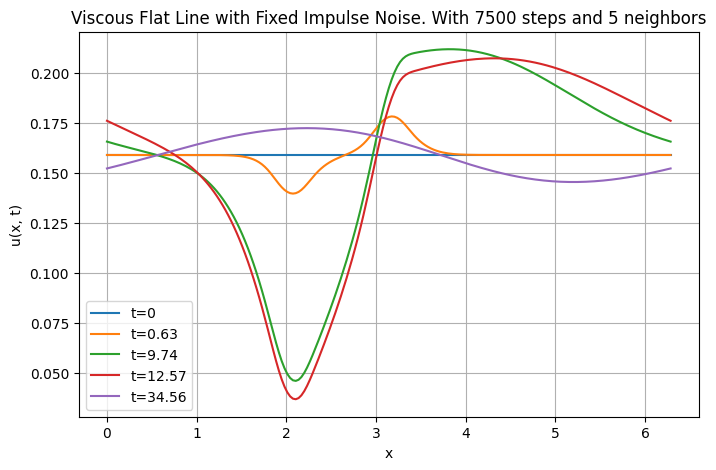

Saved animation: Flat_Line_with_Impulse_noise_7500_steps.gif


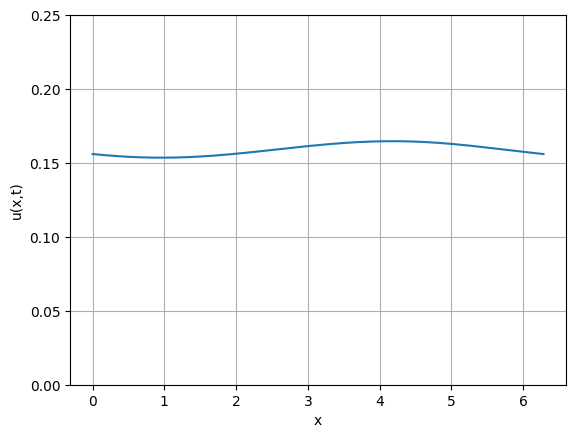

In [483]:
nt = 7500

# compute time step sizes
dt_adv = sigma * dx / max_u  # time step for advection
dt_diff = dx**2 / (2 * nu)   # time step for diffusion
# dt_diff = 999
dt = min(dt_adv,dt_diff)

nu = 0.07
neighbors = 5

for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()

    calculate_and_print_area(u, x, "Initial")

    u_hist = [u.copy()]

    plt.figure(figsize=(8, 5))
    plt.plot(x, u, label="t=0")
    plt.title(f'Viscous {name} with Fixed Impulse Noise. With {nt} steps and {neighbors} neighbors')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    # time-stepping loop
    for n in range(1, nt + 1):
        # perform an rk4 step
        u = rk4_step(u, dt, dx, nu)
        # u = update_burgers(u, dt, dx, nu)

        # plot 5 time steps of the solution progress
        if n in [100, 1550, 2000, 5500]:
            plt.plot(x, u, label=f"t={n * dt:.2f}")
  
        # Every 50 steps, add an impulse noise
        if n % 10 == 0 and n < 2000:
            u = add_impulse_noise(u, max_tries=1000, neighbors=neighbors, fraction_of_max_u=0.02)
        
        if n % math.floor((nt/300)) ==0:
            u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    plt.legend()
    plt.grid(True)
    plt.show()

    create_animation(x, u_hist, f'{name} with Impulse noise {nt} steps')

# Traffic Stop

Its still mostly a test area. The code below is based on a few articles and guides.. bit i am not sure if it was applied correcly. 
Generally about reflcetive boudary conditions and its usage in wave propagation

# Comment 5
I think the idea is good, but there are some details with implemntation that are important. Below I have modifed your code to get something that seems more correct, but make sure that it is correct what i am doing. 

Explanaition: 

First of all, if you are initating with a gaussian peak, place the red light to the right of it, as your whole system is traveling right - then you do not encounter the problems with a DECREASING soltion at the red light. Secondly,the function "enforce_reflective_boundary" is probably not doing what you want (or at least I cannot see why you would add it), as it sets the value after the red ligth (where density should be decreasing, or at least not be influenced by the red light BEHIND the car) to the value at the red ligth. The boundary that you are trying to enforce, being different behaviour before and after the red light, is violated by letting the points before and after "feel" eachother across the red ligth. We therefore need to set the $dudx[i\_ mid] = 0$ as you have done but the derivatives 

AFTER the red ligth also need a new boundary condition, as the point i_mid+1 was currently feeling point i_mid. Instead i have just used the reflective boundary condition ($u[N+1] = u[N]$ if N is the largest index, and the same with 0) keeping the derivative constant across the red light boundary from the rigth, (or whatever other boundary condition you think i applicable), and the density behaves like intended (I have commented the code where I have made changes). I hope it makes sense, otherwise write me again. Otherwise it is super nicely implemented :)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from matplotlib.animation import FuncAnimation, PillowWriter

nx = 101         # spatial points
L = 2.0 * np.pi  # domain length
dx = L / (nx - 1)
x = np.linspace(0, L, nx)
nu = 0.07      # viscosity

# midpoint (red light) index
i_mid = 90  # x[i_mid] ~ pi

# time params
nt = 3000
sigma = 0.2
max_u = 1.0

dt_adv = sigma * dx / max_u
dt_diff = dx**2 / (2 * nu)
dt = min(dt_adv, dt_diff)

def initial_condition_gaussian(x):
    gaussian = np.exp(-0.5 * ((x - np.pi) / 0.5)**2)
    area = np.trapz(gaussian, x)
    return gaussian / area

initial_conditions = {
    'Gaussian': initial_condition_gaussian
}

In [487]:
def spatial_derivatives(u, dx, nu, i_mid, red_light_on):
    dudx = np.zeros_like(u)
    d2udx2 = np.zeros_like(u)

    # periodic boundary at the ends
    dudx[0] = (u[1] - u[-2])/(2*dx)
    dudx[-1] = dudx[0]
    d2udx2[0] = (u[1] - 2*u[0] + u[-2])/(dx**2)
    d2udx2[-1] = d2udx2[0]

    # left side (1 to i_mid-1)
    for i in range(1, i_mid):
        dudx[i] = (u[i+1] - u[i-1])/(2*dx)
        d2udx2[i] = (u[i+1] - 2*u[i] + u[i-1])/(dx**2)

    if red_light_on:
        # Red light ON: impose no-flux at i_mid
        dudx[i_mid] = 0.0
        d2udx2[i_mid] = (u[i_mid-1] - 2*u[i_mid] + u[i_mid-1])/(dx**2)

        # right side: i_mid+2 to nx-1
        for i in range(i_mid+2, nx-1):
            dudx[i] = (u[i+1] - u[i-1])/(2*dx)
            d2udx2[i] = (u[i+1] - 2*u[i] + u[i-1])/(dx**2)

        dudx[i_mid+1] = 0.0
        d2udx2[i_mid+1] = (u[i_mid+2] - 2*u[i_mid+1] + u[i_mid+2])/(dx**2)
    else:
        # Red light OFF: treat the domain as continuous at i_mid
        dudx[i_mid] = (u[i_mid+1] - u[i_mid-1])/(2*dx)
        d2udx2[i_mid] = (u[i_mid+1] - 2*u[i_mid] + u[i_mid-1])/(dx**2)

        for i in range(i_mid+1, nx-1):
            dudx[i] = (u[i+1] - u[i-1])/(2*dx)
            d2udx2[i] = (u[i+1] - 2*u[i] + u[i-1])/(dx**2)

    return dudx, d2udx2

def rhs_burgers(u, dx, nu, i_mid, red_light_on):
    dudx, d2udx2 = spatial_derivatives(u, dx, nu, i_mid, red_light_on)
    return -u * dudx + nu * d2udx2

def rk4_step(u, dt, dx, nu, i_mid, red_light_on):
    k1 = rhs_burgers(u, dx, nu, i_mid, red_light_on)
    k2 = rhs_burgers(u + 0.5 * dt * k1, dx, nu, i_mid, red_light_on)
    k3 = rhs_burgers(u + 0.5 * dt * k2, dx, nu, i_mid, red_light_on)
    k4 = rhs_burgers(u + dt * k3, dx, nu, i_mid, red_light_on)
    u_new = u + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return u_new

def calculate_and_print_area(u, x, label):
    area = np.trapezoid(u, x)
    print(f"{label} area under curve: {area}")

/var/folders/kl/f84_8w7x3kg1ccbk5n2lqjg40000gn/T/ipykernel_885/115370859.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = np.trapz(gaussian, x)


Initial conditions: Gaussian
Initial area under curve: 1.0
Final area under curve: 1.0060293637426405


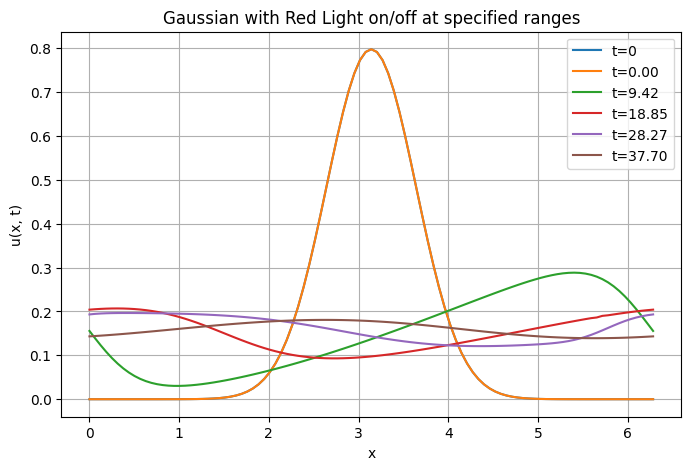

In [490]:

for name, ic_func in initial_conditions.items():
    u0 = ic_func(x)
    u = u0.copy()

    u_hist = []  # store values for animation frames

    print(f"Initial conditions: {name}")
    calculate_and_print_area(u, x, "Initial")

    plt.figure(figsize=(8, 5))
    plt.plot(x, u, label="t=0")
    plt.title(f'{name} with Red Light on/off at specified ranges')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')

    snapshot_times = [0.0, nt*dt/4, nt*dt/2, 3*nt*dt/4, nt*dt]
    snapshots = {0.0: u.copy()}

    for n in range(1, nt+1):
        # Define the red light ranges:
        # Red light ON from steps 200 to 500, and from 800 to 1400
        if (200 <= n < 500) or (1500 <= n < 2200):
            red_light_on = True
        else:
            red_light_on = False

        u = rk4_step(u, dt, dx, nu, i_mid, red_light_on)

        current_time = n * dt
        if any(abs(current_time - st) < 1e-12 for st in snapshot_times):
            snapshots[current_time] = u.copy()

        if n % math.floor((nt/200)) == 0:
            u_hist.append(u.copy())

    calculate_and_print_area(u, x, "Final")

    # Plot snapshots
    for t, u_snap in snapshots.items():
        plt.plot(x, u_snap, label=f"t={t:.2f}")

    plt.legend()
    plt.grid(True)
    plt.show()

    create_animation(x, u_hist, f"{name}_red_light_intervals")
